In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import experimental
from tensorflow.keras.layers.experimental import preprocessing



INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
#Image Classes 
# 1 - PETE
# 2 - HDPE
# 3 - V
# 4 - LDPE (we don't have a single 4 in our dataset!!)
# 5 - PP
# 6 - PS
#7 - Other 

In [3]:
#######################################
### LOAD AND RESIZE IMAGE DATA
#######################################

In [4]:
#Load Images
batch_size = 32
img_height = 200
img_width = 200

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../test", seed = 123, 
    image_size = (img_height, img_width),
    batch_size = batch_size,
    labels = 'inferred', label_mode = 'categorical')


val_ds = tf.keras.preprocessing.image_dataset_from_directory (
"../test", validation_split = 0.1, subset = "validation", seed = 123,
image_size = (img_height, img_width), batch_size = batch_size, labels = 'inferred', label_mode = 'categorical')

class_names = train_ds.class_names
print(class_names)

FileNotFoundError: [Errno 2] No such file or directory: '../test'

In [ ]:
#######################################
### VISUALIZE TRAINING SET 
########################################

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis("off")

In [42]:
########################################
### OPTIMIZE DATA FOR FASTER TRAINING 
#######################################

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
#######################################
### DATA AUGMENTATION
#######################################

normalization_layer = preprocessing.Rescaling(1./127.5, offset = -1)
data_augmentation = keras.Sequential(
[   preprocessing.RandomFlip("horizontal", input_shape = (200, 200, 3)),
    preprocessing.RandomFlip("vertical", input_shape = (200, 200, 3)),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.2),
])


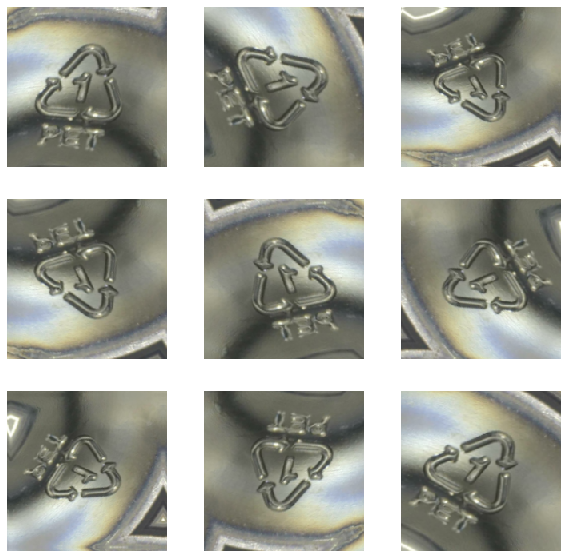

In [44]:
#######################################
### VISUALIZE DATA AUGMENTATION
#######################################

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images)
        plt.imshow(augmented_image[9].numpy().astype('uint8'))
        plt.axis("off")
    

In [45]:
####################################
### CLASSIFICATION MODEL
####################################

cnn = tf.keras.Sequential()

cnn.add(normalization_layer)

#add layers
cnn.add(data_augmentation)
cnn.add(layers.Conv2D(filters = 16, kernel_size = (3, 3), input_shape = (200, 200, 3), activation = 'relu'))
cnn.add(layers.AveragePooling2D((2, 2))) 
cnn.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')) 
cnn.add(layers.AveragePooling2D((2, 2)))
cnn.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu')) 
cnn.add(layers.AveragePooling2D((2, 2)))
cnn.add(layers.Dropout(0.05))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(units = 140, activation = 'relu'))
cnn.add(layers.Dense(units = 7, activation = 'softmax')) 

In [33]:
cnn.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [46]:
cnn.compile(loss = 'categorical_crossentropy',
           optimizer = 'adam', #keras.optimizers.SGD(),
           metrics = ['accuracy'])


In [47]:
#################################
### TRAIN MODEL
################################

history = cnn.fit(train_ds, batch_size = 32, epochs = 50 , validation_data = val_ds)





Epoch 1/50
9/9 [==============================] - 5s 493ms/step - loss: 2.6127 - accuracy: 0.1706 - val_loss: 1.9534 - val_accuracy: 0.2143
Epoch 2/50
9/9 [==============================] - 4s 477ms/step - loss: 1.9296 - accuracy: 0.2217 - val_loss: 1.8037 - val_accuracy: 0.2143
Epoch 3/50
9/9 [==============================] - 4s 479ms/step - loss: 1.8569 - accuracy: 0.2710 - val_loss: 1.7210 - val_accuracy: 0.3929
Epoch 4/50
9/9 [==============================] - 4s 470ms/step - loss: 1.8172 - accuracy: 0.3144 - val_loss: 1.6450 - val_accuracy: 0.4286
Epoch 5/50
9/9 [==============================] - 4s 466ms/step - loss: 1.7672 - accuracy: 0.3082 - val_loss: 1.6229 - val_accuracy: 0.3929
Epoch 6/50
9/9 [==============================] - 4s 471ms/step - loss: 1.7272 - accuracy: 0.3010 - val_loss: 1.6727 - val_accuracy: 0.3571
Epoch 7/50
9/9 [==============================] - 4s 463ms/step - loss: 1.6557 - accuracy: 0.3642 - val_loss: 1.6368 - val_accuracy: 0.4286
Epoch 8/50
9/9 [====

In [ ]:
#########################################
### MODEL EVALUATION
########################################

In [48]:
images = []
labels = []
for image, label in val_ds:
    images.append(image)
    labels.append(label)

_, train_acc = cnn.evaluate(train_ds, verbose=0)
print('Training Accuracy = {0:f}'.format(train_acc))
_, val_acc = cnn.evaluate(val_ds, verbose=0)
print('Validation Accuracy = {0:f}'.format(val_acc))

Training Accuracy = 0.856643
Validation Accuracy = 0.928571


In [49]:
#Compare predictions to labels 
preds = np.argmax(cnn.predict(val_ds), axis = 1) + 1
labels = np.argmax(labels[0], axis = 1) + 1
print(preds)
print(labels)
print((preds==labels).sum()/len(labels))


[1 6 5 5 7 1 1 5 3 2 1 2 5 1 3 2 2 6 4 3 6 1 2 1 2 2 2 7]
[1 6 5 5 7 1 1 5 3 2 1 2 5 1 3 2 2 6 4 3 2 1 2 2 2 2 2 7]
0.9285714285714286


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


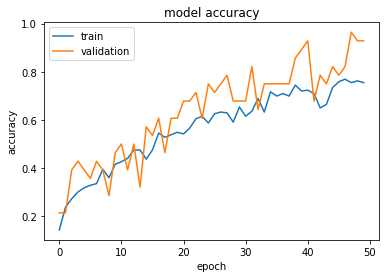

In [53]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

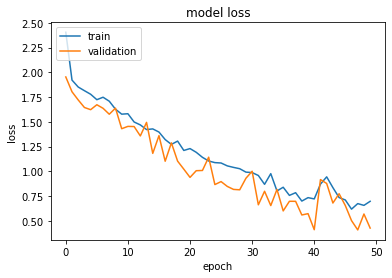

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(labels, preds)
matrix

array([[6, 0, 0, 0, 0, 0, 0],
       [1, 8, 0, 0, 0, 1, 0],
       [0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 2]])

Text(0.5, 1.0, 'Model Accuracy by Class')

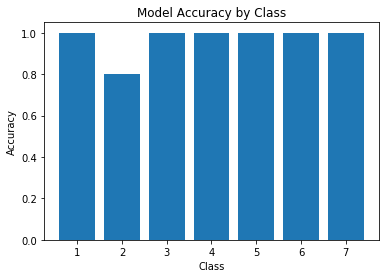

In [61]:
plt.bar(x = [1, 2, 3, 4, 5, 6, 7], height = matrix.diagonal())
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Class")

In [55]:
from sklearn.metrics import classification_report

#classification report 
print(classification_report(labels, preds, target_names = class_names))

              precision    recall  f1-score   support

           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89        10
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2

    accuracy                           0.93        28
   macro avg       0.93      0.97      0.94        28
weighted avg       0.95      0.93      0.93        28



In [66]:
############################################################
### CONVERT KERAS MODEL TO COREML MODEL FOR SWIFT FRONTEND
############################################################

In [110]:
import coremltools
from tensorflow.keras.models import load_model

In [111]:
cnn.save('cnn2.h5')

In [112]:
output_labels = ['1', '2', '3', '4', '5', '6', '7']
your_model = coremltools.converters.convert('cnn2.h5',inputs=[coremltools.ImageType()]) 
                                                

your_model.author = 'morgan'
your_model.short_description = 'Recycling Label Recognition'


Translating MIL ==> MLModel Ops: 100%|██████████| 62/62 [00:00<00:00, 63.88 ops/s]


In [113]:
your_model.save('cnn2.mlmodel')